In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import corner
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.utils import elements_to_pdic, params_to_elements
from jax.config import config
import numpyro, jax
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: good guesses for planets' mean periods

In [2]:
d = pd.read_csv("kep51/ttv.txt", delim_whitespace=True, header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809]

### define timestep dt, start/end times of integration

In [3]:
dt = 0.5 * 2
t_start, t_end = 155., 1495 + 1455
jttv = JaxTTV(t_start, t_end, dt) # jaxttv class

### set observed transit times and errors (necessary to obtain model transit times)

In [4]:
jttv.set_tcobs(tcobs, p_init, errorobs=errorobs, print_info=True)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)


### least-squares fit for initializing HMC
- defaults to LM optimization with scipy.optimize.curve_fit
- if a good guess is not found, turning on amoeba may help

initial objective function: 5448.24 (53 data)

running optimization...
objective function: 47.72 (53 data)
# elapsed time (least square): 3.6 sec


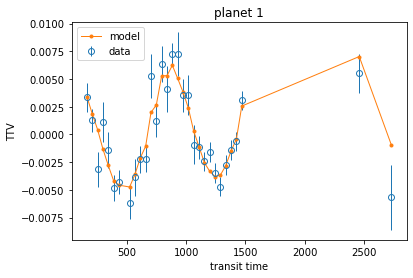

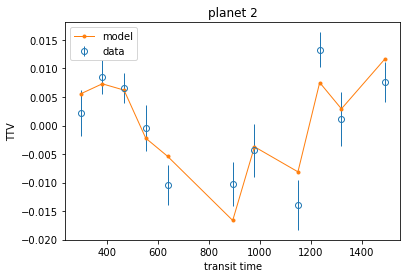

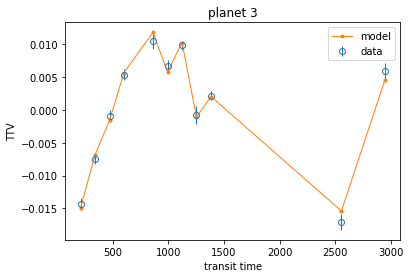

In [5]:
params_best = jttv.optim(amoeba=False, mmax=1e-4, emax=0.1)

In [6]:
tc = jttv.check_prec(params_best)

# fractional energy error (symplectic, dt=1.00e+00): 3.41e-09
# fractional energy error (Hermite, dt=4.52e-02): -5.93e-12
# max difference in tc: 5.99e-06 days (0.52 sec)


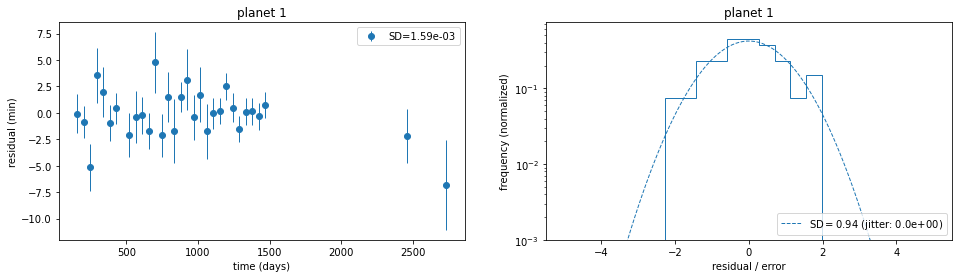

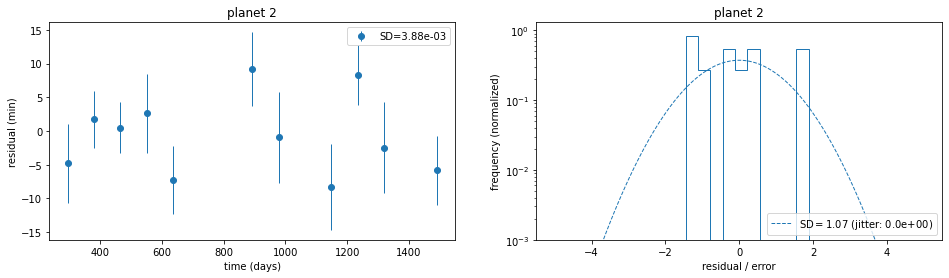

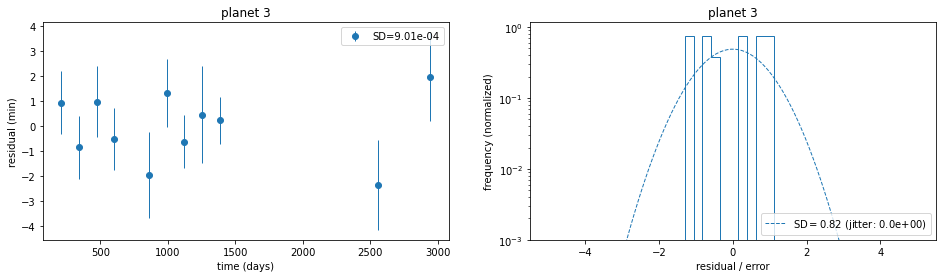

In [7]:
jttv.check_residuals(tc)

In [8]:
pdic = pd.DataFrame(elements_to_pdic(*params_to_elements(params_best, jttv.nplanet)))
print (pdic)

      pmass      period     ecosw     esinw  cosi  lnode         tic  \
0  3.300924   45.154108 -0.017186 -0.040699  -0.0    0.0  159.110265   
1  4.075007   85.314483  0.018882 -0.034824   0.0   -0.0  295.321017   
2  5.321454  130.184137  0.011666 -0.028107  -0.0   -0.0  212.023435   

        ecc     omega     lnmass      mass      cosw      sinw  
0  0.044179 -1.970355 -11.521534  0.000010 -0.389012 -0.921233  
1  0.039613 -1.073962 -11.310863  0.000012  0.476645 -0.879096  
2  0.030432 -1.177383 -11.043989  0.000016  0.383343 -0.923606  


In [9]:
%timeit jttv.get_ttvs(*params_to_elements(params_best, jttv.nplanet))

5.68 ms ± 198 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### initialize HMC
- pdic_init: dict containing best-fit values
- tic_guess: used to set priors for times of inferior conjunction
- p_guess: used to set priors for osculating periods

In [10]:
from numpyro.infer import init_to_value
import numpyro.distributions as dist
import jax.random as random

tic_guess = jnp.array([_tcobs[0] for _tcobs in jttv.tcobs])
p_guess = jnp.array(jttv.p_init)
ones = jnp.ones_like(p_guess)

pdic_init = elements_to_pdic(*params_to_elements(params_best, jttv.nplanet), 
                             outkeys=['period', 'ecc', 'cosw', 'sinw', 'cosi', 'lnode', 'tic', 'lnmass', 'mass'])
init_strategy = init_to_value(values=pdic_init)

def model(dp=5e-1, dtic=1e-1, emax=0.3, mmin=1e-7, mmax=1e-3, uniform_mass=False, tcjitter=None):
    tic = numpyro.sample("tic", dist.Uniform(low=tic_guess-dtic, high=tic_guess+dtic))
    period = numpyro.sample("period", dist.Uniform(low=p_guess-dp, high=p_guess+dp))
    ecc = numpyro.sample("ecc", dist.Uniform(low=ones*0, high=ones*emax))
    cosw = numpyro.sample("cosw", dist.Normal(scale=ones))
    sinw = numpyro.sample("sinw", dist.Normal(scale=ones))
    omega = numpyro.deterministic("omega", jnp.arctan2(sinw, cosw))
    lnode = numpyro.deterministic("lnode", ones*0)
    cosi = numpyro.deterministic("cosi", ones*0)
    
    if uniform_mass:
        mass = numpyro.sample("mass", dist.Uniform(low=ones*mmin, high=ones*mmax))
        numpyro.deterministic("lnmass", jnp.log(mass))
    else:
        lnmass = numpyro.sample("lnmass", dist.Uniform(low=ones*jnp.log(mmin), high=ones*jnp.log(mmax)))
        mass = jnp.exp(lnmass)
        numpyro.deterministic("mass", mass)

    elements = jnp.array([period, ecc*jnp.cos(omega), ecc*jnp.sin(omega), cosi, lnode, tic]).T
    numpyro.deterministic("elements", elements)

    tcmodel, ediff = jttv.get_ttvs(elements, jnp.hstack([1., mass]))
    if tcjitter is not None:
        lntcjitter = numpyro.sample("lntcjitter", dist.Uniform(low=-10, high=jnp.log(tcjitter)))
        tcjitter = numpyro.deterministic("tcjitter", jnp.exp(lntcjitter))
        tcerrmodel = jnp.sqrt(jttv.errorobs_flatten**2 + tcjitter**2)
    else:
        tcerrmodel = jttv.errorobs_flatten
        
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [11]:
pdic_init

{'period': DeviceArray([ 45.15410798,  85.31448324, 130.18413706], dtype=float64),
 'cosi': DeviceArray([-0.,  0., -0.], dtype=float64),
 'lnode': DeviceArray([ 0., -0., -0.], dtype=float64),
 'tic': DeviceArray([159.11026537, 295.32101703, 212.02343484], dtype=float64),
 'ecc': DeviceArray([0.04417854, 0.03961336, 0.03043219], dtype=float64),
 'lnmass': DeviceArray([-11.52153353, -11.31086342, -11.0439893 ], dtype=float64),
 'mass': DeviceArray([9.91428880e-06, 1.22392394e-05, 1.59829297e-05], dtype=float64),
 'cosw': DeviceArray([-0.38901152,  0.47664503,  0.38334348], dtype=float64),
 'sinw': DeviceArray([-0.92123289, -0.87909585, -0.92360585], dtype=float64)}

In [12]:
kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9, init_strategy=init_strategy)

In [13]:
nw, ns, linm, tcjitter = 100, 100, True, None  # dt=1, all data, 1h50min
#nw, ns, linm, tcjitter = 500, 500, True, None  # dt=1, all data, 15hr (A100)

In [14]:
assert num_chains <= jax.local_device_count()
mcmc = numpyro.infer.MCMC(kernel, num_warmup=nw, num_samples=ns, num_chains=num_chains)

In [15]:
output = "kep51/dt%.1f_"%jttv.dt
if not linm:
    output += "logm"
if tcjitter is not None:
    output += "jit"
output += "nw%d_ns%d_"%(nw, ns)
if num_chains > 1:
    output += "c%d_"%num_chains

In [16]:
output

'kep51/dt1.0_nw100_ns100_'

In [17]:
import os, dill
posterior = output + "mcmc.pkl"
if os.path.exists(posterior):
    print (posterior + " loaded.")
    mcmc = dill.load(open(posterior, 'rb'))
else:
    rng_key = random.PRNGKey(0)
    mcmc.run(rng_key, mmin=0, mmax=5e-4, uniform_mass=linm, tcjitter=tcjitter)
    with open(output+"mcmc.pkl", "wb") as f:
        dill.dump(mcmc, f)

sample: 100%|██████████████████████████████████████████████████| 200/200 [2:07:13<00:00, 38.17s/it, 1023 steps of size 3.42e-03. acc. prob=0.98]


In [18]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   cosw[0]     -0.45      0.23     -0.42     -0.78     -0.06      6.79      1.02
   cosw[1]      0.93      0.14      0.94      0.72      1.13      6.18      1.59
   cosw[2]      0.30      0.22      0.27      0.01      0.53      3.62      2.12
    ecc[0]      0.05      0.02      0.05      0.03      0.08      6.06      1.06
    ecc[1]      0.03      0.01      0.03      0.01      0.05      3.97      1.31
    ecc[2]      0.03      0.01      0.02      0.01      0.04      3.95      1.35
   mass[0]      0.00      0.00      0.00      0.00      0.00      4.71      1.19
   mass[1]      0.00      0.00      0.00      0.00      0.00      6.40      1.04
   mass[2]      0.00      0.00      0.00      0.00      0.00      9.04      1.13
 period[0]     45.15      0.00     45.15     45.15     45.15     12.07      0.99
 period[1]     85.31      0.00     85.31     85.31     85.32      6.34      1.39
 period[2]    130.18      0

In [19]:
samples = mcmc.get_samples()

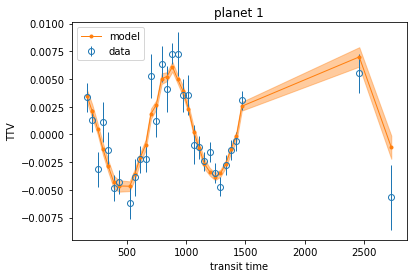

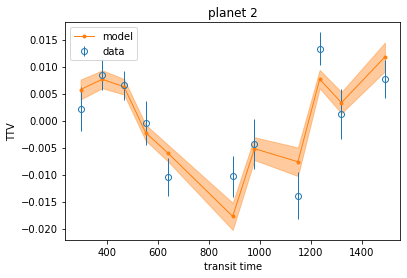

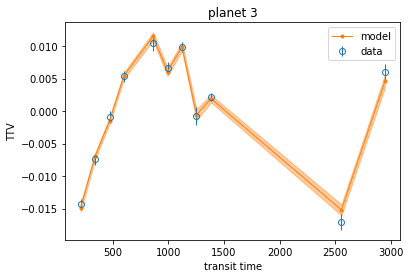

In [20]:
idx = samples['ediff']==samples['ediff']
mmodel, smodel = jnp.mean(samples['tcmodel'][idx], axis=0), jnp.std(samples['tcmodel'][idx], axis=0)
jttv.quicklook(mmodel, sigma=smodel)#, save=output+"postm")

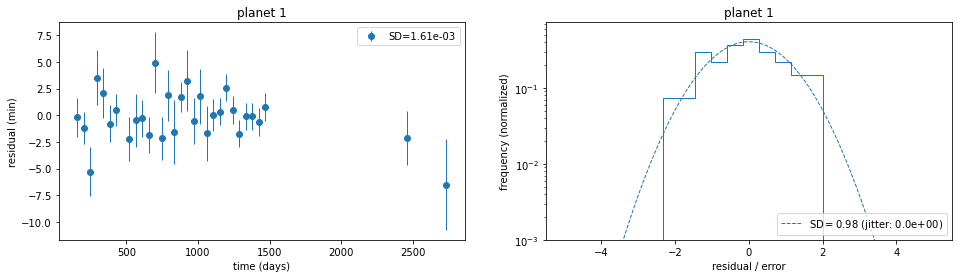

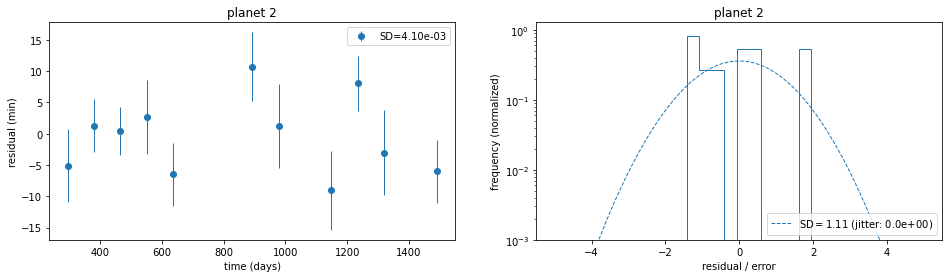

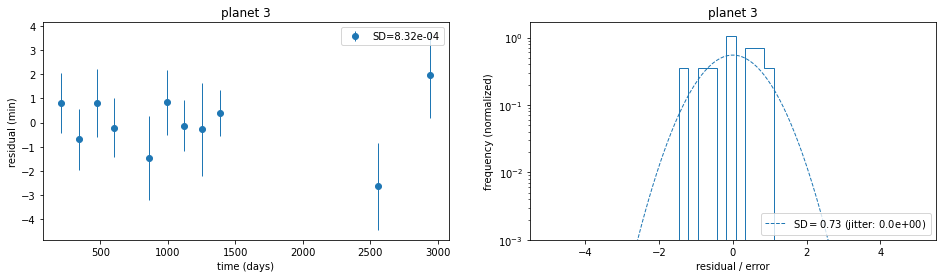

In [21]:
jttv.check_residuals(mmodel)

(array([ 5.,  7.,  7., 21., 14., 10., 12., 14.,  3.,  7.]),
 array([-8.63674765, -8.6092173 , -8.58168695, -8.5541566 , -8.52662625,
        -8.49909591, -8.47156556, -8.44403521, -8.41650486, -8.38897451,
        -8.36144416]),
 <BarContainer object of 10 artists>)

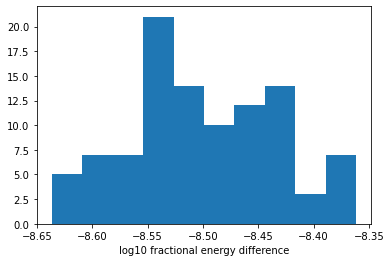

In [22]:
plt.xlabel("log10 fractional energy difference")
plt.hist(np.log10(np.abs(samples['ediff'])))

In [23]:
M_earth = 3.0034893e-6
samples['pmass'] = samples['mass'] / M_earth
keys = ['pmass', 'tic', 'period', 'ecc', 'omega']

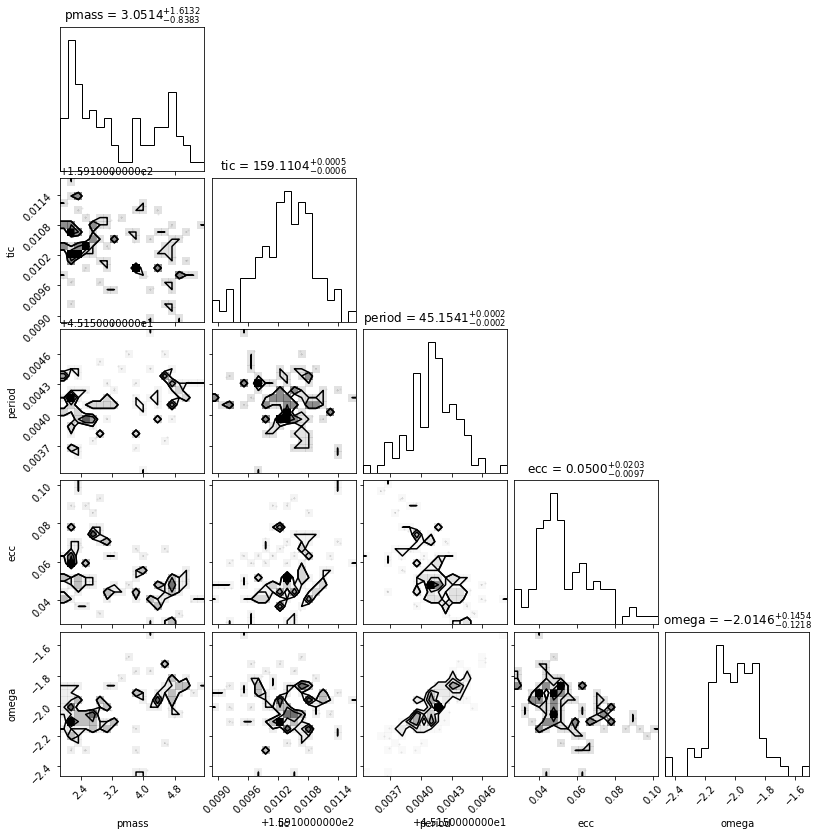

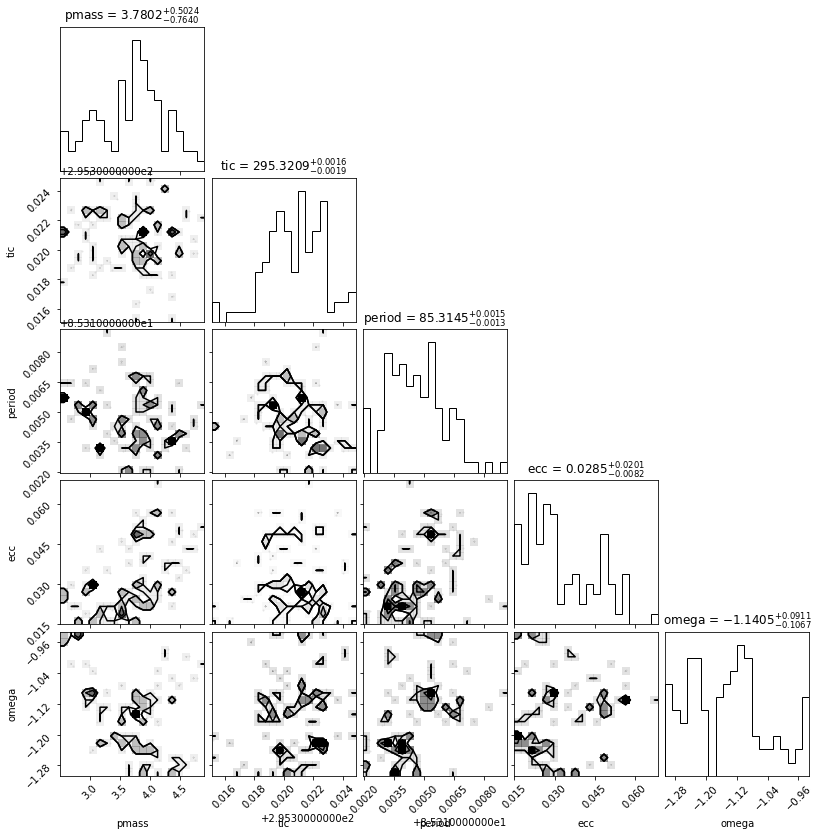

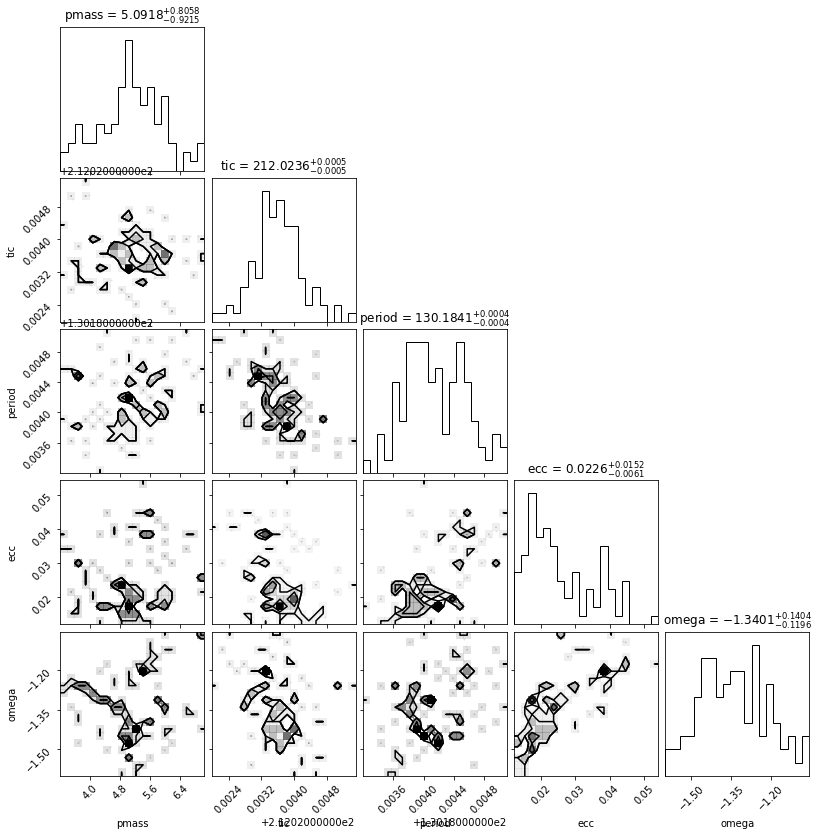

In [24]:
for j in range(jttv.nplanet):
    hyper = pd.DataFrame(data=dict(zip(keys, [samples[k][:,j] for k in keys])))
    if tcjitter is not None:
        hyper['lntcjitter'] = samples['lntcjitter']
        labels = keys + ['lntcjitter']
    else:
        labels = keys
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt=".4f")
    #plt.savefig(output+"corner%d.png"%(j+1), dpi=200, bbox_inches="tight");

### check convergence of transit times

In [26]:
jttv2 = JaxTTV(t_start, t_end, dt / 10.)
jttv2.set_tcobs(tcobs, p_init, errorobs=errorobs)

# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           0.1000 (1/451 of innermost period)


(array([ 2.,  0.,  2.,  8., 14., 16.,  4.,  1.,  2.,  4.]),
 array([-0.38113922, -0.31496342, -0.24878761, -0.18261181, -0.11643601,
        -0.05026021,  0.01591559,  0.08209139,  0.14826719,  0.21444299,
         0.28061879]),
 <BarContainer object of 10 artists>)

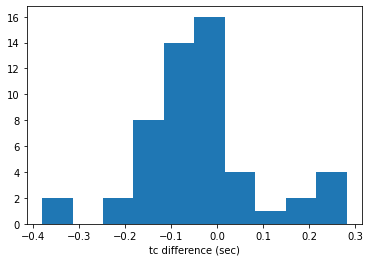

In [27]:
k = 50
tc1, ediff1 = jttv2.get_ttvs(samples['elements'][k], jnp.hstack([1., samples['mass'][k]]))
plt.xlabel("tc difference (sec)")
plt.hist(np.array(samples['tcmodel'][k] - tc1)*86400.)

## JWST

In [40]:
t_webb = 2460121.42516 - 2454833
print (t_webb)

5288.425160000101


In [131]:
sidx = 0
tcpred_d = []
for sidx in np.random.randint(0, 3000, 1000):
    es, ms = samples['elements'][sidx], jnp.hstack([1., samples['mass'][sidx]])
    tcpred, depred = jttv.get_ttvs_nojit(es, ms, t_start=t_start, t_end=t_webb+100, dt=0.05)
    tcpred_d.append(tcpred[2])
tcpred_d = np.array(tcpred_d)

In [133]:
#tcpred, depred = jttv.get_ttvs_nojit(es, ms, t_start=t_start, t_end=t_webb+50, dt=0.05)
mean, sigma = np.mean(tcpred_d, axis=0), np.std(tcpred_d, axis=0)

In [146]:
tcpred_jwst_bjd = tcpred_d[:,-1] + 2454833

In [147]:
print (np.mean(tcpred_jwst_bjd), np.std(tcpred_jwst_bjd)*1440.)

2460121.930532499 2.761008776167155


In [151]:
pd.DataFrame(data={"transit time (BJD)": tcpred_jwst_bjd}).to_csv("kepler51d_jwst_prediction.csv", index=False)

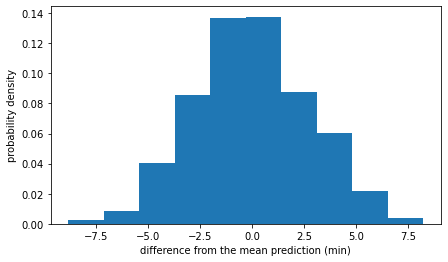

In [152]:
plt.figure(figsize=(7,4))
plt.xlabel("difference from the mean prediction (min)")
plt.ylabel("probability density")
plt.hist((tcpred_jwst_bjd-np.mean(tcpred_jwst_bjd))*1440, density=True)
plt.savefig("kepler51d_jwst_prediction.png", dpi=200, bbox_inches="tight")

In [162]:
def quicklook2(self, model, j, sigma=None, save=None, t_pred=None, title=None):
    data = self.tcobs_flatten
    unit = 1440.
    #for j in range(self.nplanet):
    idx = self.pidx==j+1
    #if not np.sum(idx):
    #    continue
    plt.figure(figsize=(7,5))
    if title is None:
        title = "planet %d"%(j+1)
    plt.title(title)
    plt.xlabel("transit time (BJD-2454833)")
    plt.ylabel("TTV (min)")
    if np.max(self.errorobs_flatten)==1:
        plt.plot(data[idx], (data - self.tcobs_linear)[idx]*unit, 'o', label='data', mfc='none')
    else:
        plt.errorbar(data[idx], (data - self.tcobs_linear)[idx]*unit, yerr=self.errorobs_flatten[idx]*unit, 
                     fmt='o', lw=1, label='data', mfc='white')
    
    tclin = self.tcobs_linear[idx]
    t0lin, plin = tclin[0], np.diff(tclin)[0]
    midx = np.round(( model - t0lin ) / plin)
    ttv = model - t0lin - plin*midx
    if sigma is None:
        plt.plot(model, ttv*unit, '.-', label='model (mean & SD)', lw=1)
    else:
        #m, s = (model - self.tcobs_linear)[idx], sigma[idx]
        plt.plot(model, ttv*unit, '.-', label='model (mean & SD)', lw=1)
        plt.fill_between(model, (ttv-sigma)*unit, (ttv+sigma)*unit, alpha=0.4, lw=1, color='C1')
    if t_pred is not None:
        plt.axvline(x=t_pred, color='gray', lw=2, ls='dashed', alpha=0.4, label='JWST!')
    plt.legend(loc='best')
    if save is not None:
        plt.savefig(save, dpi=200, bbox_inches="tight")

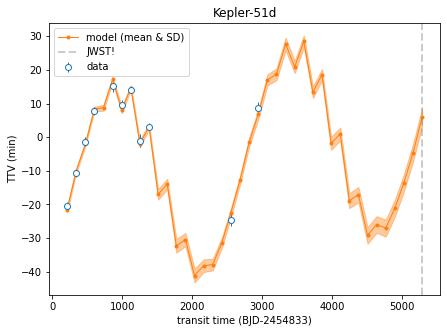

In [167]:
quicklook2(jttv, mean, 2, sigma=sigma, t_pred=t_webb, title='Kepler-51d', save="kepler51d_model.png")

In [168]:
mean_bjd = mean + 2454833

In [170]:
pd.DataFrame(data={"transit time (BJD)": mean_bjd[mean_bjd>2459697.59363]}).to_csv("kepler51d_future_transits.csv", index=False)